In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import statistics
import pandas as pd
%matplotlib inline

In [2]:
def es_point(s,p):
    max_index=np.where(s[2]==np.amax(s[2]))
    max_index=max_index[0]+p
    return max_index[0]

In [3]:
def windowed(s,window_size_half):
    s1=[]
    sv=[]
    window_size = window_size_half*2
    for i in range(len(s)-window_size):
        k = i + window_size_half
        d=s[k-window_size_half:k+window_size_half]
        dm=sum(d)/window_size
        s1.append(dm)
        dv=statistics.variance(d)
        sv.append(dv)
    return s1,sv

In [4]:
def read_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['acc'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1)
    if speed==1:
        return normalset_mean   
    nanset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    nanset_mean = nanset.mean(axis=1)
    return normalset_mean,nanset_mean

In [35]:
def plot_delayed_line(i,k,basedir,node_dir,lab,speed,filename='self_EVAL.txt',addon='_delayed'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k] + addon
    normalset_mean,nanset_mean = read_mean(files,i,speed)
    set_plt = [i*speed+2 for i in range(len(nanset_mean))]
    ax[i].plot(set_plt,nanset_mean, label=linelab)

def plot_normal_line(i,k,basedir,node_dir,lab,speed,filename='self_EVAL.txt',addon='_normal'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k] + addon
    normalset_mean,nanset_mean = read_mean(files,i,speed)
    set_plt = [i+2 for i in range(len(normalset_mean))]
    ax[i].plot(set_plt,normalset_mean, label=linelab)

In [6]:
def plot_window_mean(i,k,half_window_size,basedir,result,lab):
    s1=np.load(os.path.join(basedir,result[k]))
    p=es_point(s1,500)
    (s_mean,s_varience)=windowed(s1[2][:p],half_window_size)
    s_epo=[i+half_window_size+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label=lab[k])
def plot_window_var(i,k,half_window_size,basedir,result,lab,plotfrom=0):
    s1=np.load(os.path.join(basedir,result[k]))
    p=es_point(s1,500)
    (s_mean,s_varience)=windowed(s1[2][:p],half_window_size)
    s_epo=[i+half_window_size+1 for i in range(len(s_varience))]
    ax[i].plot(s_epo,s_varience, label=lab[k]+'_var')

In [7]:
def plot_file_window_mean(i,k,half_window_size,basedir,node_dir,lab,addon='_train'):
        files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/self_EVAL.txt')
        linelab = lab[k] + addon
        set_mean = read_mean(files,i)
        (s_mean,s_varience)=windowed(set_mean,half_window_size)
        s_epo=[i+half_window_size+2 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab)
def plot_file_window_var(i,k,half_window_size,basedir,node_dir,lab,plotfrom=0,addon='_train_var'):
        files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/self_EVAL.txt')
        linelab = lab[k] + addon
        set_mean = read_mean(files,i)
        (s_mean,s_varience)=windowed(set_mean,half_window_size)
        s_epo=[i+half_window_size+2 for i in range(len(s_varience))]
        ax[i].plot(s_epo[plotfrom:],s_varience[plotfrom:], label=linelab)

In [8]:
def plot_line(i,k,basedir,result,lab,show_max=False,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=es_point(s1,500)
    s1_epo = [i+1 for i in s1[0][:p]]
    ax[i].plot(s1_epo,s1[2][:p], label=lab[k]+addon)
    if show_max:
        index_max=np.argmax(s1[2])
        ax[i].plot(index_max,s1[2][index_max],'ks')
        ax[i].annotate('{:.3f}'.format(s1[2][index_max]),
                       xytext=(index_max,s1[2][index_max]),
                       xy=(index_max,s1[2][index_max]))

In [9]:
def plot_file_line(i,k,basedir,node_dir,lab,filename='self_EVAL.txt',addon='_train'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k] + addon
    set_mean = read_mean(files,i)
    set_plt = [i+2 for i in range(len(set_mean))]
    ax[i].plot(set_plt,set_mean, label=linelab)

## Central

In [10]:
basedir=os.path.join('zCentral')
# os.listdir(basedir)

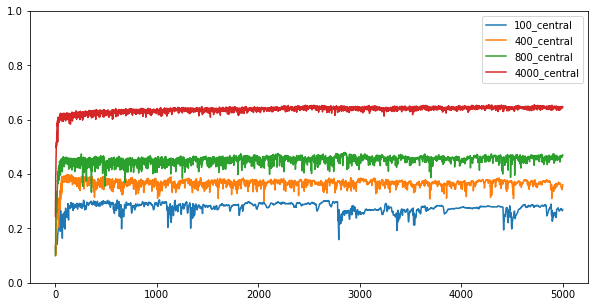

In [11]:

result=[
    '100_central.batch50.npy',
    '400_central.batch50.npy',
    '800_central.batch50.npy',
    '4000_central.batch50.npy'
]
for res in result:
    s1=np.load(os.path.join(basedir,res))
    plt.plot(s1[0],s1[2], label=res[:-12])
    plt.gcf().set_size_inches(10, 5)
    plt.ylim([0, 1])
    plt.legend()

## Data Dispersion

In [12]:
# basedir=os.path.join('DataDispersion')
# # os.listdir(basedir)

## Bad Node

In [13]:
basedir=os.path.join('BadNode')
# os.listdir(basedir)

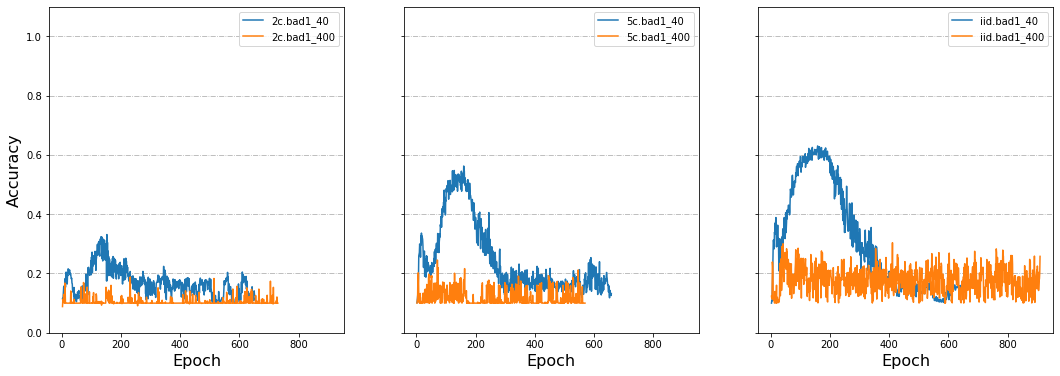

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 6))

result=[
 '2c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-015142.npy',
 '2c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-031558.npy',
 '5c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-023155.npy',
 '5c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-004052.npy',
 '11d.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-020918.npy',
 '11d.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-060927.npy'
       ]

lab=[
 '2c.bad1_40',
 '2c.bad1_400',
 '5c.bad1_40',
 '5c.bad1_400',
 'iid.bad1_40',
 'iid.bad1_400'
       ]

node_dir = [
    'bad2c40',
    'bad2c400',
    'bad5c40',
    'bad5c400',
    'badiid40',
    'badiid400'
]

for i in range(3):    
    for j in range(2):
        k = i*2+j
        half_window_size=25
        
#         plot_window_mean(i,k,half_window_size,basedir,result,lab)
#         plot_file_window_mean(i,k,half_window_size,basedir,node_dir,lab)
        
    
#         plot_window_var(i,k,half_window_size,basedir,result,lab)
#         plot_file_window_var(i,k,half_window_size,basedir,node_dir,lab)


        plot_line(i,k,basedir,result,lab)
#         plot_file_line(i,k,basedir,node_dir,lab,filename='self_EVAL.txt')
        

    ax[i].set_xlabel('Epoch',fontsize=16)
    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[0].set_ylabel('Accuracy',fontsize=16)
    ax[i].legend() 

## Local Steps

In [15]:
basedir=os.path.join('LocalStep')
os.listdir(basedir)

['2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
 '2c.10w.4000.loc10.earlystop500.20200502-105042.npy',
 '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
 '5c.10w.4000.loc10.earlystop500.20200501-203358.npy',
 'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
 'iid.10w.4000.loc10.earlystop500.20200502-151734.npy',
 'loc2c10s',
 'loc2c1s',
 'loc5c10s',
 'loc5c1s',
 'lociid10s',
 'lociid1s']

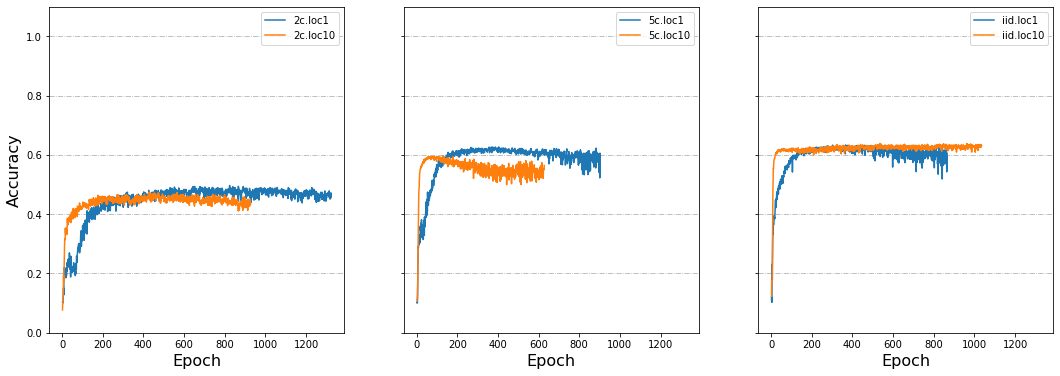

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 6))

result=[
'2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
'2c.10w.4000.loc10.earlystop500.20200502-105042.npy',
'5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
'5c.10w.4000.loc10.earlystop500.20200501-203358.npy',
'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
'iid.10w.4000.loc10.earlystop500.20200502-151734.npy'
]

lab=[
    '2c.loc1',
    '2c.loc10',
    '5c.loc1',
    '5c.loc10',
    'iid.loc1',
    'iid.loc10'
]

node_dir = [
 'loc2c1s',
 'loc2c10s',
 'loc5c1s',
 'loc5c10s',
 'lociid1s',
 'lociid10s'
]


x = 2



for i in range(3):
    
    for j in range(x):
        k= i*x+j
        half_window_size=25
        
#         plot_window_mean(i,k,half_window_size,basedir,result,lab)
#         plot_file_window_mean(i,k,half_window_size,basedir,node_dir,lab)
        
    
#         plot_window_var(i,k,half_window_size,basedir,result,lab)
#         plot_file_window_var(i,k,half_window_size,basedir,node_dir,lab)


        plot_line(i,k,basedir,result,lab)
#         plot_file_line(i,k,basedir,node_dir,lab,filename='self_EVAL.txt')
        

    ax[i].set_xlabel('Epoch',fontsize=16)
    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[0].set_ylabel('Accuracy',fontsize=16)
    ax[i].legend() 

## Share Data

In [17]:
basedir=os.path.join('ShareData')
os.listdir(basedir)

['zOLD']

## Late update in some node

In [23]:
basedir=os.path.join('DelayUpdate')
# os.listdir(basedir)

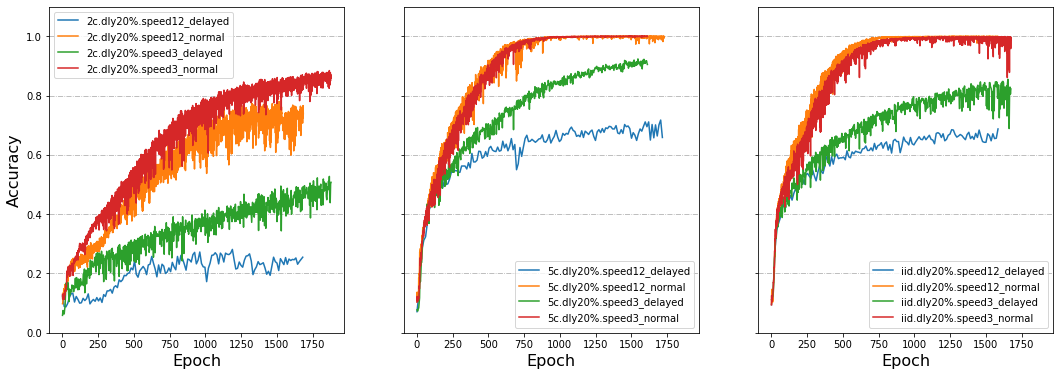

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 6))

# in order: dly8-30/12/3, dly20, dly32
result=[
    '2c.40w.4000.dly8.speed3.loc1.earlystop500.20200503-013135.npy',
    '2c.40w.4000.dly20.speed3.loc1.earlystop500.20200502-160017.npy',
    '2c.40w.4000.dly32.speed3.loc1.earlystop500.20200430-223516.npy',
    '2c.40w.4000.dly8.speed12.loc1.earlystop500.20200502-161123.npy',
    '2c.40w.4000.dly8.speed30.loc1.earlystop500.20200503-084238.npy',
        
   
    '5c.40w.4000.dly8.speed3.loc1.earlystop500.20200502-160044.npy',
    '5c.40w.4000.dly20.speed3.loc1.earlystop500.20200504-180902.npy',
    '5c.40w.4000.dly32.speed3.loc1.earlystop500.20200503-210047.npy', 
    '5c.40w.4000.dly8.speed12.loc1.earlystop500.20200502-171548.npy',
    '5c.40w.4000.dly8.speed30.loc1.earlystop500.20200502-182343.npy',
        
    
    'iid.40w.4000.dly8.speed3.loc1.earlystop500.20200502-193120.npy',
    'iid.40w.4000.dly20.speed3.loc1.earlystop500.20200503-002016.npy',
    'iid.40w.4000.dly32.speed3.loc1.earlystop500.20200502-184247.npy', 
    'iid.40w.4000.dly8.speed12.loc1.earlystop500.20200502-133739.npy',
    'iid.40w.4000.dly8.speed30.loc1.earlystop500.20200503-184146.npy', 
]

lab=[
    '2c.dly20%.speed3',
    '2c.dly50%.speed3',
    '2c.dly80%.speed3',
    '2c.dly20%.speed12',
    '2c.dly20%.speed30',
        
   
    '5c.dly20%.speed3',
    '5c.dly50%.speed3',
    '5c.dly80%.speed3', 
    '5c.dly20%.speed12',
    '5c.dly20%.speed30',
        
    
    'iid.dly20%.speed3',
    'iid.dly50%.speed3',
    'iid.dly80%.speed3', 
    'iid.dly20%.speed12',
    'iid.dly20%.speed30', 
]


node_dir = [
    'du2c1',
    'du2c2',
    'du2c3',
    'du2c4',
    'du2c5',
    'du5c1',
    'du5c1',
    'du5c3',
    'du5c4',
    'du5c5',
    'duiid1',
    'duiid2',
    'duiid3',
    'duiid4',
    'duiid5'
]

speed_list = [3,3,3,12,30,3,3,3,12,30,3,3,3,12,30]


for i in range(3):
    
    for j in [3,0]:
        
        k = i*5+j
        half_window_size=25
        speed = speed_list[k]
        
#         plot_window_mean(i,k,half_window_size,basedir,result,lab)

    
#         plot_window_var(i,k,half_window_size,basedir,result,lab)



#         plot_line(i,k,basedir,result,lab)

        plot_delayed_line(i,k,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        plot_normal_line(i,k,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        

    ax[i].set_xlabel('Epoch',fontsize=16)
    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[0].set_ylabel('Accuracy',fontsize=16)
    ax[i].legend() 

## Evaluate by node

In [20]:
basedir=os.path.join('EvalTest')
os.listdir(basedir)

['2c.10w.4000_node_EVL.loc1.earlystop500.20200502-172929.npy',
 '5c.10w.4000_node_EVL.loc1.earlystop500.20200502-092327.npy',
 'evl2c',
 'evl5c',
 'evliid',
 'iid.10w.4000_node_EVL.loc1.earlystop500.20200502-141431.npy']

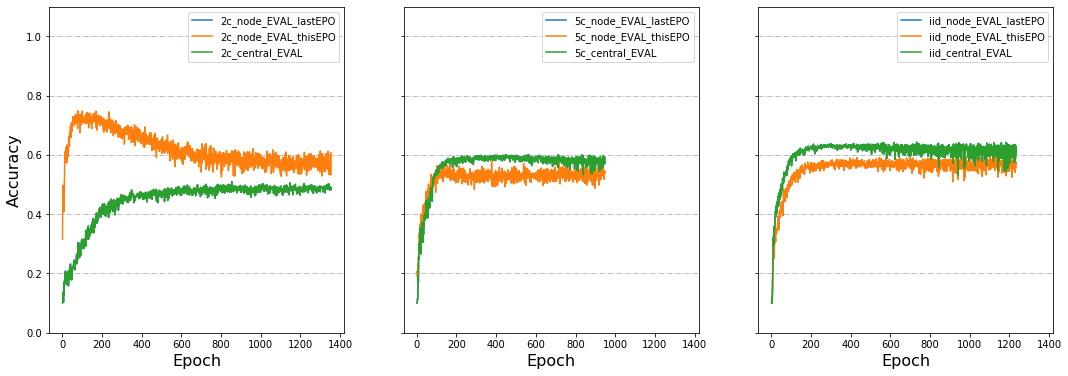

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 6))


result=[
    '2c.10w.4000_node_EVL.loc1.earlystop500.20200502-172929.npy',
    '5c.10w.4000_node_EVL.loc1.earlystop500.20200502-092327.npy',
    'iid.10w.4000_node_EVL.loc1.earlystop500.20200502-141431.npy'
]

lab=[
    '2c',
    '5c',
    'iid'   
]

node_dir = [
    'evl2c',
    'evl5c',
    'evliid'
]


for i in range(3):
    k = i
    plot_file_line(i,k,basedir,node_dir,lab,filename='node_EVAL_before_training.txt',addon='_node_EVAL_lastEPO')
    plot_file_line(i,k,basedir,node_dir,lab,filename='node_EVAL_after_training.txt',addon='_node_EVAL_thisEPO')
    plot_line(i,k,basedir,result,lab,addon='_central_EVAL')
        

    ax[i].set_xlabel('Epoch',fontsize=16)
    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[0].set_ylabel('Accuracy',fontsize=16)
    ax[i].legend() 